In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
matplotlib.style.use('ggplot')
from torchvision.datasets import MNIST
import os
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import io
import math 
import cv2

from typing import *
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm, trange

# NN
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import STL10

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Distribution, Bernoulli, Normal
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy

# other  libraries...!!!
%matplotlib inline
import argparse
from skimage.util import random_noise

import time

In [53]:
#############################
#        CLASS              #
############################


# output features for the encoder and input features for the decoder
features = 80
# define a simple linear VAE

class LinearVAE(nn.Module):
    
    # 4 linear layers. MINST data set 96*96*3 image = 27648. 
    
    def __init__(self):
        
        super(LinearVAE, self).__init__()
        #FUNCTIONS FOR ENCODER
        self.fc1 = nn.Linear(12288, 6144)
        self.fc2 = nn.Linear(6144, 4608)
        self.fc3 = nn.Linear(4608, 2304)
        self.fc4 = nn.Linear(2304, 1152)
        self.fc5 = nn.Linear(1152, features*2)
        #FUNCTIONS FOR DECODER
        self.fc6 = nn.Linear(features, 1152)
        self.fc7 = nn.Linear(1152, 2304)
        self.fc8 = nn.Linear(2304, 4608)
        self.fc9 = nn.Linear(4608,6144)
        self.fc10 = nn.Linear(6144, 12288)



    #ENCODER
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        h4 = F.relu(self.fc4(h3)) # pass the input through the VAE’s encoder layers.
        h5 = self.fc5(h4)
        h5=h5.view(-1, 2, features)
        return h5
    #DECODER  
    def decode(self, z):
        h6 = F.relu(self.fc6(z))
        h7 = F.relu(self.fc7(h6))
        h8 = F.relu(self.fc8(h7))
        h9 = F.relu(self.fc9(h8))
        h10 = torch.sigmoid(self.fc10(h9))
        return h10
    #REPARAMETERIZE
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        #Returns a new tensor with the exponential of the elements of the input tensor input
        std = torch.exp(0.5*log_var) 
        #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    #FORWARD FUNCTION  
    def forward(self, x,high_res_image):
        self.high_res_image = high_res_image
        # encoding
         #Applies the rectified linear unit function element-wise.
        x_org = x
        x = self.encode(x)  # pass the input through the VAE’s encoder layers.
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #latent vector 
        # decoding, pass the latent vector through the first decoder. 
        #then get the reconstruction of the inputs by giving the outputs as unputs to the second decoder layer. 
        reconstruction = self.decode(z) #self.dec2(x))
        
        BCE, KLD, loss = self.elbo(x_org, reconstruction, mu, log_var)
        
        return reconstruction, mu, log_var , BCE, KLD, loss, z
    
    #LOSS FUNCTION  
    def elbo(self, x, reconstruction, mu, log_var,b1=1,b2=0.75) :
  
        bce_loss = binary_cross_entropy(reconstruction, self.high_res_image, reduction='sum')
        BCE = bce_loss 
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        #MSE = nn.MSELoss(reconstruction, self.high_res_image)
        
        loss = b1 * KLD + BCE #+ MSE * b2
        
        
        return BCE, KLD, loss
        

In [54]:
#############################
#        PARAMETERS          #
############################

batch_size = 64
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)  
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA) 
  return low_res_image, image

In [5]:
from torchvision.datasets import STL10

class STL10dataset(STL10):
  def __getitem__(self, index:int):
    img = self.data[index]

    img, target = pixalate_image(np.transpose(img, (1, 2, 0)))

    if self.transform is not None:
        img = self.transform(img)

    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target

In [6]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def compare_images(target, ref):  
    return (psnr(target, ref), ssim(target, ref, multichannel =True))

In [7]:
# transforms for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    #transforms.RandomHorizontalFlip(p=0.25),
    #transforms.RandomPerspective(p=0.25),
    #transforms.ColorJitter(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    ])

# transforms for test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])

# transforms for original image
target_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((64, 64))
                            ])

In [8]:
# train and validation data
train_data = STL10dataset(
    root='./data',
    split = 'train',
    download=True,
    transform=train_transform,
    target_transform=target_transform
)

val_data = STL10dataset(
    root='./data',
    split = 'test',
    download=True,
    transform=test_transform,
    target_transform=target_transform
)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [9]:
# Split data into validation and test
test_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4)), len(val_data)))
val_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4))))

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

In [11]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

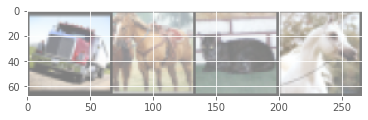

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))


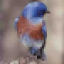

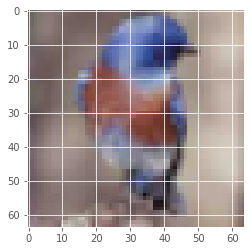

In [13]:

#choose witch image you want to see from 60000
single_image = 1

#take the labels for each train image 


with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    #data = data.to(device)
    x = images[1].size()
    # Reshape image
    plt.imshow(images[1].permute(1, 2, 0))

white_torch = images[1]

torchvision.transforms.ToPILImage()(white_torch)

In [14]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.size())
compare_images(images[1].permute(1, 2, 0).numpy(),labels[1].permute(1, 2, 0).numpy())

torch.Size([64, 3, 64, 64])


(72.94600358345143, 0.9053669227442479)

In [15]:
#############################
#     TRAINING FUNCTION     #
############################

def fit(model, dataloader):
    
    start = time.time()
    model.train()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
    mse_running_loss = 0.0
  
    
    
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, high_res = data
        
        data = data.to(device)
        data = data.view(data.size(0), -1)

        high_res = high_res.to(device)
        high_res = high_res.view(data.size(0), -1)

        optimizer.zero_grad()
        start = time.time()
        reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
        
        
        running_loss +=   loss.item()
        bce_running_loss += bce.item()
        kl_running_loss += kl.item()
        #mse_running_loss += mse.item()
        loss.backward()
        optimizer.step()
        end = time.time()
        #print("Time inside fit: ", end-start)
    train_loss = running_loss/len(dataloader.dataset)
    train_loss_bce = bce_running_loss/len(dataloader.dataset)
    train_loss_kl = kl_running_loss/len(dataloader.dataset)
    #train_loss_mse = mse_running_loss/len(dataloader.dataset)
    

   
    return train_loss, train_loss_bce, train_loss_kl

"""### The Validation Function"""

#############################
#     VALIDATE FUNCTION     #
############################
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
    mse_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            data = data.view(data.size(0), -1)

            high_res = high_res.to(device)
            high_res = high_res.view(data.size(0), -1)

            reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
            
            running_loss += loss.item()
            bce_running_loss += bce.item()
            kl_running_loss += kl.item()
            #mse_running_loss += mse.item()

            
    val_loss = running_loss/len(dataloader.dataset)
    val_loss_bce = bce_running_loss/len(dataloader.dataset)
    val_loss_kl = kl_running_loss/len(dataloader.dataset)
    #train_loss_mse = mse_running_loss/len(dataloader.dataset)


    return val_loss, val_loss_bce, val_loss_kl


In [56]:
"""#### Initializing the Model, the Optimizer and the Loss Function"""
epochs = 100
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [57]:
#############################
#            RUN            #
############################

train_loss = []
train_loss_bce = []
train_loss_kl = []
train_loss_mse = []

val_loss = []
val_loss_bce = []
val_loss_kl = []
val_loss_mse = []

start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_loss_bce, train_epoch_loss_kl = fit(model, train_loader)    
    end = time.time()
    
    val_epoch_loss, val_epoch_loss_bce, val_epoch_loss_kl = validate(model, test_loader)

    
    print(end-start)
    train_loss.append(train_epoch_loss)
    train_loss_bce.append(train_epoch_loss_bce)
    train_loss_kl.append(train_epoch_loss_kl)
    #train_loss_mse.append(train_epoch_loss_mse)
    
    val_loss.append(val_epoch_loss)
    val_loss_bce.append(val_epoch_loss_bce)
    val_loss_kl.append(val_epoch_loss_kl) 
    #val_loss_mse.append(val_epoch_loss_mse)   
    
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")





Epoch 1 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

9.296446561813354
Train Loss: 40625818.1594
Val Loss: 8123.8736
Epoch 2 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f388a1ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f388a1ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/50 [00:00<?, ?it/s]


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
    if w.is_alive():  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError
: AssertionErrorcan only test a child process: can only test a child process



21.958770275115967
Train Loss: 8098.2495
Val Loss: 8151.6047
Epoch 3 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

34.73976111412048
Train Loss: 8079.3514
Val Loss: 8085.9759
Epoch 4 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

47.62714743614197
Train Loss: 8070.3764
Val Loss: 8131.2278
Epoch 5 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

60.176796674728394
Train Loss: 8127.6693
Val Loss: 8078.9809
Epoch 6 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

72.76962876319885
Train Loss: 8066.6250
Val Loss: 8104.5033
Epoch 7 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

85.37594962120056
Train Loss: 8003.6507
Val Loss: 7975.4704
Epoch 8 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

97.9401581287384
Train Loss: 7889.8033
Val Loss: 7926.0941
Epoch 9 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

110.52024221420288
Train Loss: 7870.3376
Val Loss: 7860.1113
Epoch 10 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

123.13647556304932
Train Loss: 7847.0083
Val Loss: 7856.9985
Epoch 11 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

135.78924751281738
Train Loss: 7805.5558
Val Loss: 7753.6251
Epoch 12 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

149.11875438690186
Train Loss: 7732.2660
Val Loss: 7717.0968
Epoch 13 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

161.74162697792053
Train Loss: 7702.5335
Val Loss: 7736.5847
Epoch 14 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

174.3923134803772
Train Loss: 7689.3377
Val Loss: 7690.5865
Epoch 15 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

187.03472256660461
Train Loss: 7682.5269
Val Loss: 7704.1004
Epoch 16 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

199.644779920578
Train Loss: 7671.9026
Val Loss: 7678.7703
Epoch 17 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

212.22184658050537
Train Loss: 7668.7020
Val Loss: 7659.8067
Epoch 18 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

224.93888187408447
Train Loss: 7657.7546
Val Loss: 7655.2049
Epoch 19 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

237.54540586471558
Train Loss: 7653.2433
Val Loss: 7658.0575
Epoch 20 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

250.17942333221436
Train Loss: 7647.8996
Val Loss: 7695.2593
Epoch 21 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

262.85363030433655
Train Loss: 7650.0622
Val Loss: 7668.7074
Epoch 22 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

275.51144218444824
Train Loss: 7640.4336
Val Loss: 7689.5076
Epoch 23 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

288.16953444480896
Train Loss: 7660.2767
Val Loss: 7670.4693
Epoch 24 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

300.84129643440247
Train Loss: 7639.8767
Val Loss: 7671.7220
Epoch 25 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

313.45472240448
Train Loss: 7638.0477
Val Loss: 7649.5636
Epoch 26 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

326.15066599845886
Train Loss: 7627.6558
Val Loss: 7636.4847
Epoch 27 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

338.7324583530426
Train Loss: 7626.6949
Val Loss: 7644.2048
Epoch 28 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

351.42760705947876
Train Loss: 7624.7942
Val Loss: 7643.2270
Epoch 29 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

364.0815134048462
Train Loss: 7622.8880
Val Loss: 7649.7344
Epoch 30 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

376.76785492897034
Train Loss: 7619.4247
Val Loss: 7639.8566
Epoch 31 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

390.1223599910736
Train Loss: 7614.7555
Val Loss: 7640.7828
Epoch 32 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

402.7793462276459
Train Loss: 7623.6698
Val Loss: 7638.7049
Epoch 33 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

415.46488213539124
Train Loss: 7612.6223
Val Loss: 7645.3460
Epoch 34 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

428.17362093925476
Train Loss: 7615.9959
Val Loss: 7639.5535
Epoch 35 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

440.7891299724579
Train Loss: 7611.4006
Val Loss: 7639.8573
Epoch 36 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

453.42384004592896
Train Loss: 7611.1938
Val Loss: 7628.3576
Epoch 37 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

466.0625355243683
Train Loss: 7603.7734
Val Loss: 7646.2061
Epoch 38 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

478.7517280578613
Train Loss: 7603.6460
Val Loss: 7620.6803
Epoch 39 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

491.37536811828613
Train Loss: 7602.4296
Val Loss: 7629.1669
Epoch 40 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

504.0148468017578
Train Loss: 7600.2761
Val Loss: 7633.9204
Epoch 41 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

516.6741099357605
Train Loss: 7598.2978
Val Loss: 7625.1369
Epoch 42 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

529.3925385475159
Train Loss: 7594.5933
Val Loss: 7637.3780
Epoch 43 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

542.0963931083679
Train Loss: 7592.5313
Val Loss: 7643.0440
Epoch 44 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

554.8201901912689
Train Loss: 7594.7562
Val Loss: 7622.1384
Epoch 45 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

567.5333125591278
Train Loss: 7595.6206
Val Loss: 7666.5578
Epoch 46 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

580.2771480083466
Train Loss: 7596.2718
Val Loss: 7622.6032
Epoch 47 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

592.9004311561584
Train Loss: 7582.6836
Val Loss: 7628.1207
Epoch 48 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

605.5833442211151
Train Loss: 7583.2034
Val Loss: 7629.1374
Epoch 49 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

618.441529750824
Train Loss: 7583.4645
Val Loss: 7650.6066
Epoch 50 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

631.1589455604553
Train Loss: 7584.4612
Val Loss: 7660.1332
Epoch 51 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

643.8112735748291
Train Loss: 7574.4925
Val Loss: 7618.8494
Epoch 52 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

656.5328016281128
Train Loss: 7569.9636
Val Loss: 7622.8322
Epoch 53 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

669.1914947032928
Train Loss: 7560.6764
Val Loss: 7606.1201
Epoch 54 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

681.8302001953125
Train Loss: 7552.8135
Val Loss: 7588.0507
Epoch 55 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

694.5511622428894
Train Loss: 7542.0281
Val Loss: 7590.1767
Epoch 56 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

707.2296657562256
Train Loss: 7537.0087
Val Loss: 7582.2742
Epoch 57 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

719.8833348751068
Train Loss: 7530.2411
Val Loss: 7585.7183
Epoch 58 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

732.5168271064758
Train Loss: 7532.0376
Val Loss: 7582.9251
Epoch 59 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

745.2090513706207
Train Loss: 7527.8915
Val Loss: 7565.9063
Epoch 60 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

757.858195066452
Train Loss: 7516.3534
Val Loss: 7592.0898
Epoch 61 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

770.5662784576416
Train Loss: 7519.3019
Val Loss: 7605.0492
Epoch 62 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

783.274087190628
Train Loss: 7518.6377
Val Loss: 7581.7819
Epoch 63 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

795.9819293022156
Train Loss: 7515.0883
Val Loss: 7563.0282
Epoch 64 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

808.7700066566467
Train Loss: 7503.5997
Val Loss: 7560.5702
Epoch 65 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

821.4286031723022
Train Loss: 7502.8511
Val Loss: 7577.6725
Epoch 66 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

834.093474149704
Train Loss: 7500.3266
Val Loss: 7560.3381
Epoch 67 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

846.7707476615906
Train Loss: 7497.2378
Val Loss: 7615.0740
Epoch 68 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

859.5944502353668
Train Loss: 7501.3656
Val Loss: 7561.8547
Epoch 69 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

872.3061826229095
Train Loss: 7487.3160
Val Loss: 7566.6968
Epoch 70 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

885.1031153202057
Train Loss: 7485.4223
Val Loss: 7566.5726
Epoch 71 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

897.7715058326721
Train Loss: 7486.2624
Val Loss: 7580.1499
Epoch 72 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

910.4282162189484
Train Loss: 7481.5836
Val Loss: 7595.2546
Epoch 73 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

923.2694084644318
Train Loss: 7487.7535
Val Loss: 7566.1677
Epoch 74 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

935.9388642311096
Train Loss: 7478.8222
Val Loss: 7559.4967
Epoch 75 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

948.5564000606537
Train Loss: 7476.2286
Val Loss: 7554.6831
Epoch 76 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

961.5034415721893
Train Loss: 7473.0649
Val Loss: 7566.4399
Epoch 77 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

974.3179659843445
Train Loss: 7469.9890
Val Loss: 7563.5375
Epoch 78 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

987.056574344635
Train Loss: 7474.1447
Val Loss: 7613.2266
Epoch 79 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

999.854531288147
Train Loss: 7474.1549
Val Loss: 7575.5196
Epoch 80 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1012.7267503738403
Train Loss: 7461.6903
Val Loss: 7561.3389
Epoch 81 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1025.5860159397125
Train Loss: 7456.9959
Val Loss: 7589.4064
Epoch 82 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1038.3008675575256
Train Loss: 7459.8467
Val Loss: 7568.0949
Epoch 83 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1051.0726263523102
Train Loss: 7461.4504
Val Loss: 7583.3224
Epoch 84 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1063.866090297699
Train Loss: 7454.7270
Val Loss: 7568.2147
Epoch 85 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1076.6643958091736
Train Loss: 7446.2114
Val Loss: 7586.8833
Epoch 86 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1089.4682478904724
Train Loss: 7444.5503
Val Loss: 7590.2989
Epoch 87 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1102.4029204845428
Train Loss: 7440.7933
Val Loss: 7565.7485
Epoch 88 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1115.232130765915
Train Loss: 7439.4705
Val Loss: 7571.6796
Epoch 89 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1129.1143400669098
Train Loss: 7441.5314
Val Loss: 7569.2276
Epoch 90 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1141.9279618263245
Train Loss: 7439.7485
Val Loss: 7581.1035
Epoch 91 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1154.7139689922333
Train Loss: 7441.2818
Val Loss: 7575.3430
Epoch 92 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1167.5561833381653
Train Loss: 7425.7644
Val Loss: 7578.0582
Epoch 93 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1180.510761976242
Train Loss: 7429.5249
Val Loss: 7572.9901
Epoch 94 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1193.4062254428864
Train Loss: 7425.7137
Val Loss: 7579.8330
Epoch 95 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1206.1918959617615
Train Loss: 7426.6325
Val Loss: 7588.9499
Epoch 96 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1219.0870401859283
Train Loss: 7418.0113
Val Loss: 7577.1781
Epoch 97 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1231.901413679123
Train Loss: 7411.3683
Val Loss: 7584.7567
Epoch 98 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1244.7210669517517
Train Loss: 7408.2292
Val Loss: 7591.7620
Epoch 99 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1257.6162712574005
Train Loss: 7410.0960
Val Loss: 7586.5743
Epoch 100 of 100


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1270.3991792201996
Train Loss: 7412.6876
Val Loss: 7582.6662


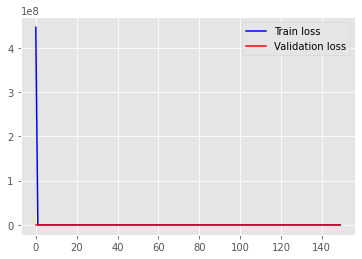

In [19]:
plt.plot(list(range(0,epochs)), train_loss, color='blue', label='Train loss')
plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

In [20]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image

with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    input, target = next(dataiter)
    print(input.size())
    data = input[1].to(device)
    data = data.view(1, 12288)
    labels = target[1].to(device)
    labels = labels.view(1, 12288)

    reconstruction, mu, log_var, bce, kl, loss ,z = model(data.float(),labels)
   

torch.Size([64, 3, 64, 64])


In [21]:
input_img = input[1]
target_img = target[1]
out_img = reconstruction.cpu()
out_img = out_img.view(data.size(0), -1)
out_img = out_img.reshape(3,64,64)

Text(0.5, 1.0, 'VAE_linear')

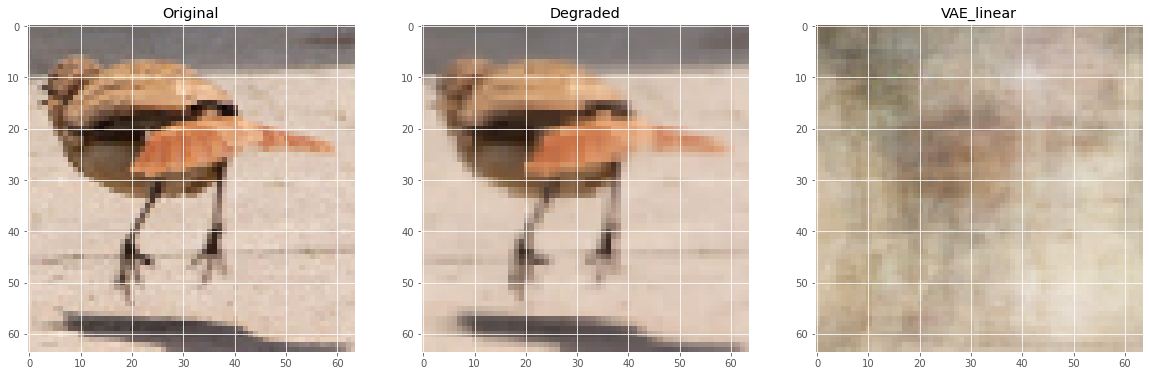

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(target_img.permute(1, 2, 0).numpy())
axs[0].set_title('Original')
axs[1].imshow(input_img.permute(1, 2, 0).numpy())
axs[1].set_title('Degraded')
axs[2].imshow(out_img.permute(1, 2, 0).numpy())
axs[2].set_title('VAE_linear')

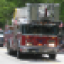

In [ ]:
torchvision.transforms.ToPILImage()(input_img)

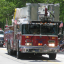

In [ ]:
torchvision.transforms.ToPILImage()(target_img)

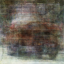

In [ ]:
torchvision.transforms.ToPILImage()(out_img)

In [ ]:
compare_images(input_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(71.19232833362518, 0.8409072136439492)

In [ ]:
compare_images(out_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(63.75076328419056, 0.42331068308896175)

In [23]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                          shuffle=False, num_workers=2)

In [24]:
#############################
#     TEST FUNCTION     #
############################
def test(model, dataloader):
    mse_loss = nn.functional.mse_loss
    model.eval()
    running_loss = 0.0
    mse_running_loss = 0.0
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            data = data.view(data.size(0), -1)
            

            high_res = high_res.to(device)
            high_res = high_res.view(data.size(0), -1)
            

            reconstruction, _, _, _, _, loss, _ = model(data,high_res)

            psnr, ssim = compare_images(high_res.cpu().reshape(3,64,64).permute(1, 2, 0).numpy(), reconstruction.cpu().view(data.size(0), -1).reshape(3,64,64).permute(1, 2, 0).numpy())
            
            running_loss += loss.item()
            psnr_running_loss += psnr
            ssim_running_loss += ssim
            mse_running_loss += mse_loss(reconstruction, high_res)          
            
            
    test_loss = running_loss/len(dataloader.dataset)
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)
    mse = mse_running_loss/len(dataloader.dataset)


    return test_loss, psnr, ssim, mse.cpu().item()


In [25]:
loss, psnr, ssim, mse = test(model, val_loader)

  0%|          | 0/3200 [00:00<?, ?it/s]

In [26]:
loss, psnr, ssim, mse

(7583.651943359375,
 63.07791642300751,
 0.3662960864268031,
 0.036139603704214096)

In [51]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):
         
    # assume RGB image
    target_data = target
    ref_data = ref

    diff = ref_data - target_data
    
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def compare_images(target, ref):  
    return (psnr(target, ref), ssim(target, ref, multichannel =True))

def metrics_on_loader(dataloader):
    mse_loss = nn.functional.mse_loss
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0
    mse_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data
            data = data.cpu()
            high_res = high_res.cpu()
              

            _psnr, _ssim = compare_images(high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))).numpy(), data.view((data.size(2), data.size(3), data.size(1))).numpy())
            mse_running_loss += mse_loss(data,high_res)
            
            psnr_running_loss += _psnr
            ssim_running_loss += _ssim            
            
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)
    mse = mse_running_loss/len(dataloader.dataset)


    return psnr, ssim,mse


In [52]:
metrics_on_loader(val_loader)

  0%|          | 0/3200 [00:00<?, ?it/s]

(74.49303179623652, 0.9506464652740495, tensor(0.0027))